In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Input
from sklearn.metrics import log_loss

print(tf.__version__)
print(tf.executing_eagerly())

2.16.1
True


# 1. Preparing the data

In [3]:
import zipfile

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zip_ref:
    zip_ref.extractall()
    
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224) 
train_files = glob('/kaggle/working/train/*.jpg')
test_files = glob('/kaggle/working/test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return tf.keras.applications.inception_resnet_v2.preprocess_input(img) 

def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

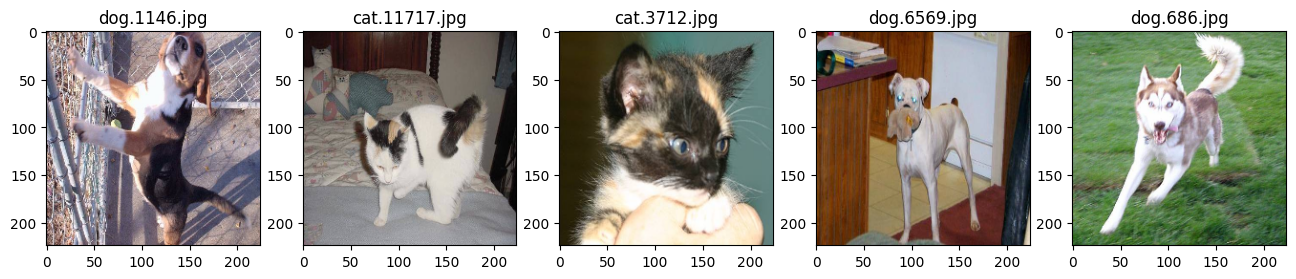

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:5], 1):
    subplot = fig.add_subplot(1, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

# 2. Base_model initialization
(InceptionResNetV2)

In [6]:
input_tensor = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
input_shape = [IMG_SIZE[0], IMG_SIZE[1], 3]

base_model = InceptionResNetV2(input_tensor=input_tensor,
                               weights='imagenet',
                               include_top=False,
                               input_shape=input_shape)

base_model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "inception_resnet_v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 54,336,736 (207.28 MB)

 Trainable params: 54,276,192 (207.05 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [7]:
val_samples = int(len(train_files) * 0.2)

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

In [8]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid', 
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
model.fit(train_data,
          steps_per_epoch=10,
          epochs=10,
          validation_data=validation_data)

Epoch 1/10


I0000 00:00:1725626779.958438      70 service.cc:145] XLA service 0x7c10b0002060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725626779.958527      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725626779.958533      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1725626793.610103      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 5s/step - accuracy: 0.7330 - loss: 0.9765 - val_accuracy: 0.9828 - val_loss: 0.0872
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9805 - loss: 0.0979 - val_accuracy: 0.9828 - val_loss: 0.0627
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9869 - loss: 0.0538 - val_accuracy: 0.9932 - val_loss: 0.0429
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9989 - loss: 0.0102 - val_accuracy: 0.9914 - val_loss: 0.0488
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.9824 - val_loss: 0.0728
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9942 - loss: 0.0314 - val_accuracy: 0.9914 - val_loss: 0.0502
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9905 - loss: 0.0711 - val_accuracy: 0.9894 - val_loss: 0.0496
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9966 - loss: 0.0147 - val_accuracy: 0.9906 - val_loss: 0.0532
Epo

In [10]:
def plots_for_metrics(model_name):
    epochs = range(1, len(model_name.history['accuracy']) + 1)
    
    plt.plot(epochs, model_name.history['accuracy'], label='train accurarcy')
    plt.plot(epochs, model_name.history['val_accuracy'], label='val accurarcy')
    plt.title('accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, model_name.history['loss'], label='train loss')
    plt.plot(epochs, model_name.history['val_loss'], label='val loss')
    plt.title('loss')
    plt.legend()
    
    plt.show()

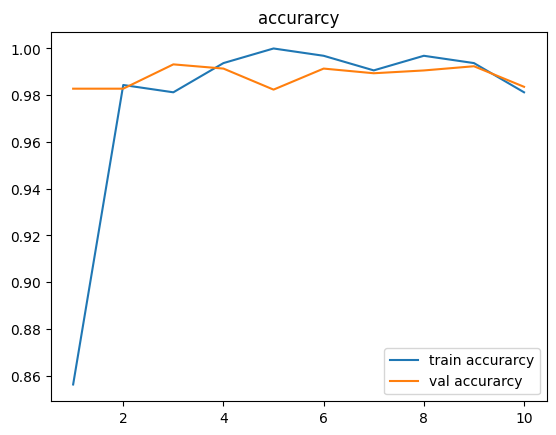

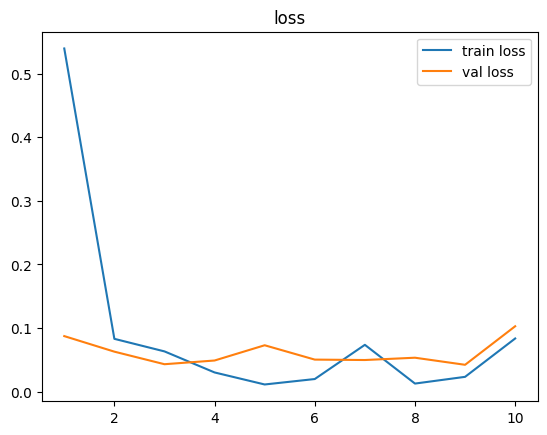

In [11]:
plots_for_metrics(model.history)

In [12]:
val_pred = model.predict(validation_data[0], steps=len(validation_data[0]))
log_loss(validation_data[1], val_pred)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step


0.0977680737644761

# 3. Data preparation for sending 

In [13]:
del validation_data
del train_data
del val_pred

In [14]:
test_data = []

for image in test_files:
    test_data.append(np.array(load_image(image)))
    
test_data = np.array(test_data)

In [15]:
test_pred = model.predict(test_data, steps=len(test_files))

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 177s 14ms/step


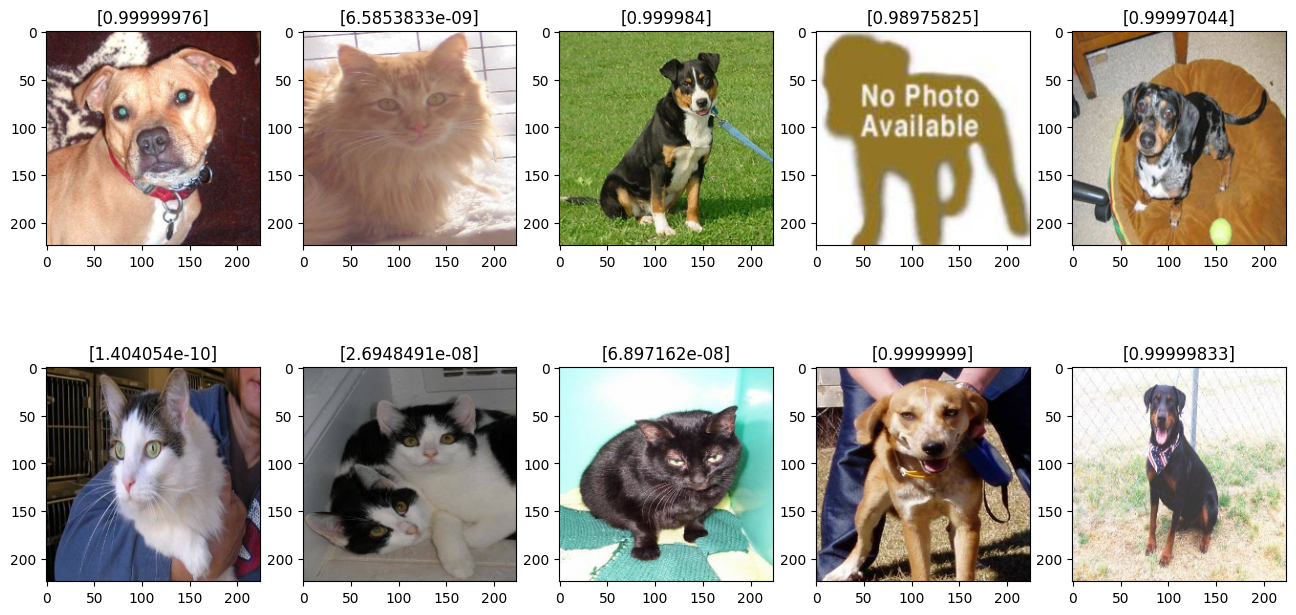

In [16]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title(score)
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE) 
    subplot.imshow(img)

In [17]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

/tmp/ipykernel_24/3821844124.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))
